# Data collection 

In [1]:
import os
import time
import uuid
import cv2


In [2]:
images_path = os.path.join('data', 'images')
number_images = 30
print('done')

done


In [5]:
# cap = cv2.VideoCapture(1) #0 is iPhone camera, 0 is MacBook camera 
for imgnum in range(number_images):
    print('collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(images_path, f'{str(uuid.uuid1())}.jpeg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print('done')

collecting image 0
collecting image 1
collecting image 2
collecting image 3
collecting image 4
collecting image 5
collecting image 6
collecting image 7
collecting image 8
collecting image 9
collecting image 10
collecting image 11
collecting image 12
collecting image 13
collecting image 14
collecting image 15
collecting image 16
collecting image 17
collecting image 18
collecting image 19
collecting image 20
collecting image 21
collecting image 22
collecting image 23
collecting image 24
collecting image 25
collecting image 26
collecting image 27
collecting image 28
collecting image 29
done


In [124]:
#!labelme
# Launches label me software

2024-09-02 16:19:40,713 [INFO   ] __init__:get_config:67- Loading config file from: /Users/liamstothart/.labelmerc


## The next step to go through is reviewing the data nd building an image loading function

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [106]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [107]:
images = tf.data.Dataset.list_files('data/images/*.jpeg', shuffle=True) 

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpeg'

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [109]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [110]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [ ]:
image_gen = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_gen.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# Data Splitting
I have randomly split up the data by hand for ease. I am going to use the following cell to allocate the labels to match

In [5]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)   

# Albumentation
we can use this to increase the amount of data significantly

In [6]:
import albumentations as alb

In [7]:
augmentor = alb.Compose([alb.RandomCrop(width=1920, height=1080), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [8]:
img = cv2.imread(os.path.join('data', 'train', 'images',
                           '6c7ddbf8-6928-11ef-ba2b-f278a7eac9cc.jpeg'))

In [9]:
with open(os.path.join('data', 'train', 'labels', '6c7ddbf8-6928-11ef-ba2b-f278a7eac9cc.json'), 'r') as f:
    label = json.load(f)

In [10]:
label['shapes'][0]['points']

[[821.7647058823529, 340.0], [1192.3529411764705, 792.9411764705882]]

In [11]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [12]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))
#These values are the dimension of the screen, would need changing

In [13]:
coords

[0.42800245098039214,
 0.3148148148148148,
 0.6210171568627451,
 0.7342047930283224]

In [14]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

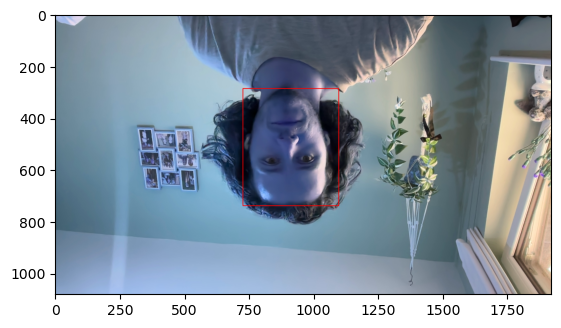

In [15]:

cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1920,1080]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1920,1080]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## We now need a pipeline
Loop through all of our folders and grab everything. We then check if the image has an annotation and if not then we assign it one. After that we are creating 60 images per base image.

In [16]:
#Not confident for this one
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

y_max is less than or equal to y_min for bbox [0.37285539215686275, 0.6688453159041394, 0.44332107843137253, 0.3474945533769064, 'face'].
image must be numpy array type
x_max is less than or equal to x_min for bbox [0.6976102941176471, 0.7233115468409586, 0.5934436274509804, 0.2984749455337691, 'face'].
y_max is less than or equal to y_min for bbox [0.5934436274509804, 0.5925925925925927, 0.9580269607843136, 0.2222222222222222, 'face'].
x_max is less than or equal to x_min for bbox [0.6669730392156862, 0.7723311546840959, 0.5505514705882353, 0.4891067538126363, 'face'].
x_max is less than or equal to x_min for bbox [0.4984681372549019, 0.8921568627450981, 0.21966911764705888, 0.1623093681917212, 'face'].
x_max is less than or equal to x_min for bbox [0.6332720588235293, 0.8431372549019608, 0.5076593137254902, 0.43464052287581695, 'face'].
x_max is less than or equal to x_min for bbox [0.6332720588235293, 0.8376906318082789, 0.5045955882352942, 0.440087145969499, 'face'].
x_max is less 

In [17]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

2024-09-04 16:22:42.565789: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-04 16:22:42.565832: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-04 16:22:42.565844: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-04 16:22:42.566082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-04 16:22:42.566098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [19]:

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [20]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [21]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2760, 2760, 540, 540, 600, 600)

In [23]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [24]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


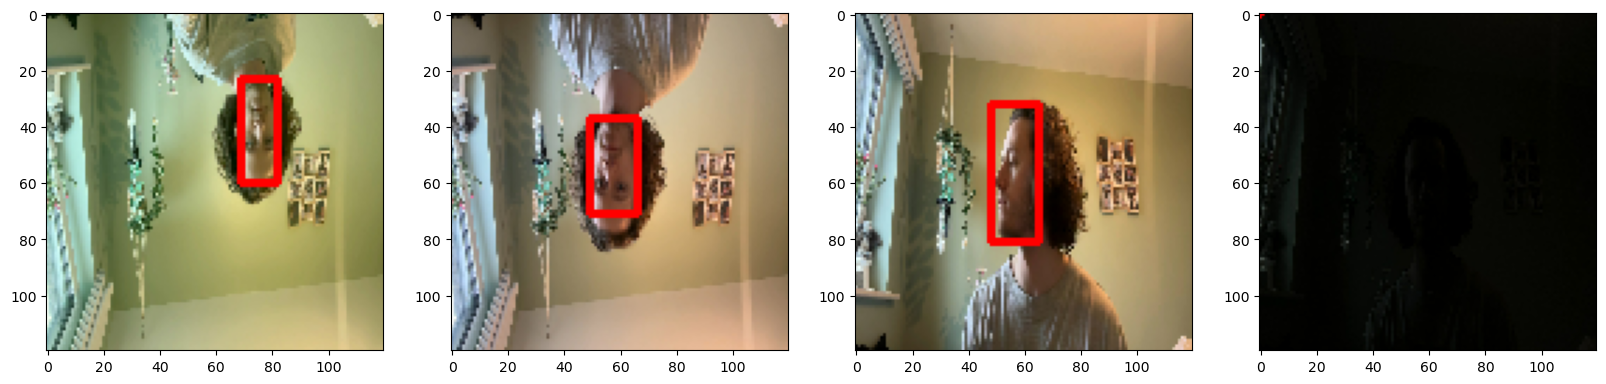

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = np.copy(res[0][idx])  # Ensure it's a writable array
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Deep learning with a functional API

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [27]:
vgg = VGG16(include_top=False)

In [28]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [29]:
facetracker = build_model()

In [30]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
X, y = train.as_numpy_iterator().next()

In [32]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


2024-09-04 16:22:55.725397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-09-04 16:22:55.734653: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


In [33]:
classes, coords

(array([[0.6598327 ],
        [0.6632241 ],
        [0.7060213 ],
        [0.5980493 ],
        [0.7295137 ],
        [0.71749705],
        [0.7000459 ],
        [0.6003759 ]], dtype=float32),
 array([[0.57354593, 0.6548699 , 0.19810753, 0.52943355],
        [0.68325067, 0.5673851 , 0.28573778, 0.5756828 ],
        [0.5814642 , 0.6033377 , 0.37944543, 0.5294971 ],
        [0.64855254, 0.5762209 , 0.33619678, 0.5566973 ],
        [0.6075827 , 0.6147388 , 0.392064  , 0.5064069 ],
        [0.6046479 , 0.61175346, 0.36568695, 0.5484615 ],
        [0.62857145, 0.6314792 , 0.34847474, 0.5837372 ],
        [0.64295685, 0.62702477, 0.31034437, 0.5789322 ]], dtype=float32))

# Define Losses and Optimisers
We need to slow down the learning rate so we dont get vanishing gradient or overfitting

In [34]:
batches_per_epoch = len(train)  # Length of your training dataset

# The decay steps might correspond to how often you want to decay, typically after each epoch
decay_steps = batches_per_epoch

# Calculate decay rate based on your formula
decay_rate = 1.0 / 0.75  # equivalent to reducing by 25% every epoch

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # Staircase=True ensures that the learning rate decays in a step-wise fashion
)


In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [36]:
def localization_loss(y_true, yhat):
    print(f"Type of y true is:{type(y_true)}")
    
    # Coordinate loss: Sum of squared differences in coordinates
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]), axis=-1)
    
    # Calculate height and width for true and predicted boxes
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]
    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]
    
    # Size loss: Sum of squared differences in width and height
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred), axis=-1)
    
    # Total loss: Combine coordinate and size losses
    total_loss = tf.reduce_mean(delta_coord + delta_size)
    
    return total_loss

In [37]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [38]:
classloss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
regressloss = localization_loss

In [39]:
print(y[0])
print(classes)
print(localization_loss(y[1], coords))
print(classloss(y[0], classes))

[[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]]
[[0.6598327 ]
 [0.6632241 ]
 [0.7060213 ]
 [0.5980493 ]
 [0.7295137 ]
 [0.71749705]
 [0.7000459 ]
 [0.6003759 ]]
Type of y true is:<class 'numpy.ndarray'>
tf.Tensor(2.7725835, shape=(), dtype=float32)
tf.Tensor(0.75039375, shape=(), dtype=float32)


# Train Neural network


In [40]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        X = tf.cast(X, tf.float32)
        y = [tf.cast(yi, tf.float32) for yi in y]
        print(f"Shape of X: {X.shape}")
        print(f"Shape of y[0]: {y[0].shape}")
        print(f"Shape of y[1]: {y[1].shape}")
    
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            print(f'classes type is = {type(classes)}')
            print(f'coords type is = {type(coords)}')
            print(f'y[0] type is = {type(y[0])}')
            print(f'y[1] type is = {type(y[1])}')
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [41]:
model = FaceTracker(facetracker)

In [42]:
model.compile(opt, classloss, regressloss)

In [43]:
#Train 
logdir='logs'

In [44]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
Shape of X: (None, 120, 120, None)
Shape of y[0]: <unknown>
Shape of y[1]: <unknown>
classes type is = <class 'tensorflow.python.framework.ops.SymbolicTensor'>
coords type is = <class 'tensorflow.python.framework.ops.SymbolicTensor'>
y[0] type is = <class 'tensorflow.python.framework.ops.SymbolicTensor'>
y[1] type is = <class 'tensorflow.python.framework.ops.SymbolicTensor'>


ValueError: Cannot take the length of shape with unknown rank.

In [459]:
print(y[0])
print(type(y[0]))
print(classes)
print(type(classes))
print(f"Shape of y[0]: {y[0].shape}")  # Expecting (batch_size, 1) or (batch_size,)
print(f"Shape of classes: {classes.shape}")  # Expecting (batch_size, 1) or (batch_size,)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
<class 'numpy.ndarray'>
[[0.3693117 ]
 [0.4223253 ]
 [0.35749513]
 [0.319959  ]
 [0.32675365]
 [0.39804435]
 [0.36071685]
 [0.32579508]]
<class 'numpy.ndarray'>
Shape of y[0]: (8, 1)
Shape of classes: (8, 1)
